# WIRC+Pol Convenience Functions Tutorial

This tutorial shows you how to use some of our convenience functions that package all the previous tutorials into just a few lines. Since a lot of the action will be going on behind the scenes we highly recommend that you complete the first three tutorials before using these functions. Even after that, we recommend you dig into the code a bit to see what it's doing and understand some of the default options better. 

There are two kinds of convenience functions: dataset reduction functions and plotting functions. 

## Dataset Reduction Functions

Dataset reduction functions are here to help you reduce a complete dataset with ease. This requires the dataset to be generally well behaved, and overall this best works when you have good background frames. 

The functions generally follow the same form: they take input file lists, extract the spectra for a single source and then save a new wirc object fits file for each input file to the output directory. Each background method that you choose to use will create its own subdirectory in the output directory. Within that subdirectory you'll also find a directory that holds an extraction summary image for each file. These images can help diagnose extraction issues. 

The basic usage of these functions is displayed below, but dig in to the code options a bit more for advanced usage. 

### reduce_dataset

The reduce_datset function accepts a filelist and source position as input and automatically extracts the spectra

Here's an example use: 

In [ ]:
import numpy as np
import wirc_drp.dataset as wd

#This is a very simple function just to help gather your files.
def make_list(start, stop, path, prefix):
    file_list = [path+prefix+str(x).zfill(4)+'_cal.fits' for x in np.arange(start, stop+1)]
    return np.array(file_list)

#Generate your file list
filelist = make_list(2334, 2373, '/scr/data/Calibrated Files/20190319/Auto_Reduced/', 'wirc')


wd.reduce_dataset(filelist, #The file list
                [758,1093], #The detector coordinates of the 0th order of your source [x,y] in pixels
                bkg_fnames = None, #In this case we don't have a list of background files to input
                output_path = "/scr/mblanchaer/Data/WIRC+Pol/Elia2-25/190319/", #The output data path
                verbose=False, #We don't want ALL of the status outputs
                less_verbose=True, #But we want some
                bkg_methods = ["cutout_median"], #We'll just use the cutout_median background subtraction here
                in_slit=False, #The source is not in the slit
                parallel=True, #Let's reduce the files in parallel to make things go faster
                n_processes=None, #Let's use the maximum number of processes (minues 1) that our machine allows
                fixed_width=7) #We'll use a fixed width for the extraction of each file -> this improves stability

You could also use it with a set of background files:

In [ ]:
#Generate your file list
filelist = make_list(2334, 2373, '/scr/data/Calibrated Files/20190319/Auto_Reduced/', 'wirc')

#Generate your background file list
bkg_filelist = make_list(2329, 2333, '/scr/data/Calibrated Files/20190319/Auto_Reduced/', 'wirc')

wd.reduce_dataset(filelist, 
                [758,1093], 
                bkg_fnames = bkg_filelist, #This time we include the background file list
                output_path = "/scr/mblanchaer/Data/WIRC+Pol/Elia2-25/190319/", 
                verbose=False, 
                less_verbose=True, 
                bkg_methods = ["cutout_median","scaled_bkg"], #There are now more background subtraction options open 
                                                              #to us since we have the backgroud files
                in_slit=False, 
                parallel=True, 
                n_processes=None,
                nclosest = 10, #This allows you to set a limit on the number of background frames you want to use, 
                               #and picks the closest in time
                fixed_width=7) 

### reduce_ABAB_dataset

This function is very much like reduce_dataset, except that it doesn't accept a list of background files, but instead assumes that you observed in an ABAB dither pattern. 

Here's an example use: 

In [ ]:
filelist = make_list(72, 80, '/scr/data/Calibrated Files/20200807/Auto_Reduced/', 'image')

wd.reduce_ABAB_dataset(filelist, #The file list
                       [720,1100],#The detector coordinates of the 0th order of your source [x,y] in the A position
                       [754,1102],#The detector coordinates of the 0th order of your source [x,y] in the B position
                       output_path = "/scr/mblanchaer/Data/WIRC+Pol/Elia2-25/200807/", #The output data path
                       verbose=False, #We don't want ALL of the status outputs
                       less_verbose=True, #But we want some
                       bkg_methods = ["scaled_bkg","cutout_median"],
                       parallel=True,
                       fixed_width=7)

### reduce_dataset_distance

In this version the pipeline automatically finds your source (based on your initial guess) and uses any frame that is a set number of pixels away as part of the background library. 

In [ ]:
filelist = make_list(72, 80, '/scr/data/Calibrated Files/20200807/Auto_Reduced/', 'image')

wd.reduce_dataset_distance(filelist, #The file list
                       [720,1100],#The average detector coordinates of the 0th order of your source
                       output_path = "/scr/mblanchaer/Data/WIRC+Pol/Elia2-25/200807/", #The output data path
                       verbose=False, #We don't want ALL of the status outputs
                       less_verbose=True, #But we want some
                       bkg_methods = ["scaled_bkg","cutout_median"],
                       parallel=True,
                       fixed_width=7)

## Plotting Functions

There are also a few built-in functions that can be used to give you a quick look at some of your data.

### Extraction Sumary

The first summary plot shows you the mean extracted spectra from each of the four traces as well as a set of plots for each trace showing all of the extracted spectra. This can help you spot a significant number of outliers in your dataset. Often having just a few doesn't skew your results a lot. 

In [7]:
data_directory = "/scr/mblanchaer/Data/WIRC+Pol/CFHT_BD4/200905/scaled_bkg/"

64
Found 64 files


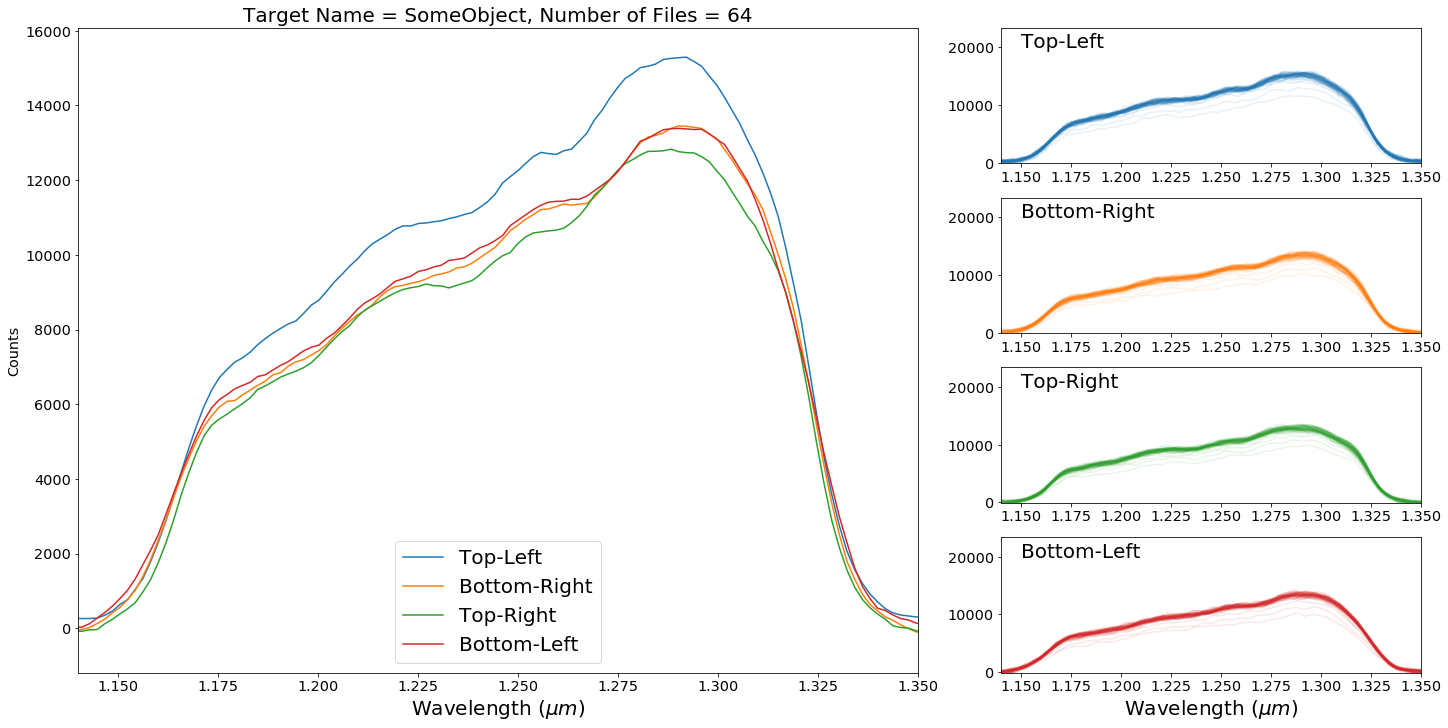

In [9]:
import wirc_drp.dataset as wd
wd.plot_dataset_extraction_summary(data_directory,save=False,verbose=True,target_name="SomeObject")

### Polarization Summary

This plot provides a summary of the polarized spectrum measured from your dataset. The top row shows all of the individual q and u measurements, as well as the mean and median. The middle row shows the median values for each of the trace pairs individually and combined, and displays the 1-sigma error ranges based on the standard error on the mean of each wavelength bin. The bottom row shows p and theta for the combined. 

Note: by default this is uncalibrated data (i.e. no system Mueller matrix has been applied). You can turn on the calibration by setting `calibrate=True` as a keyword argument, but this is currently an experimental feature. 

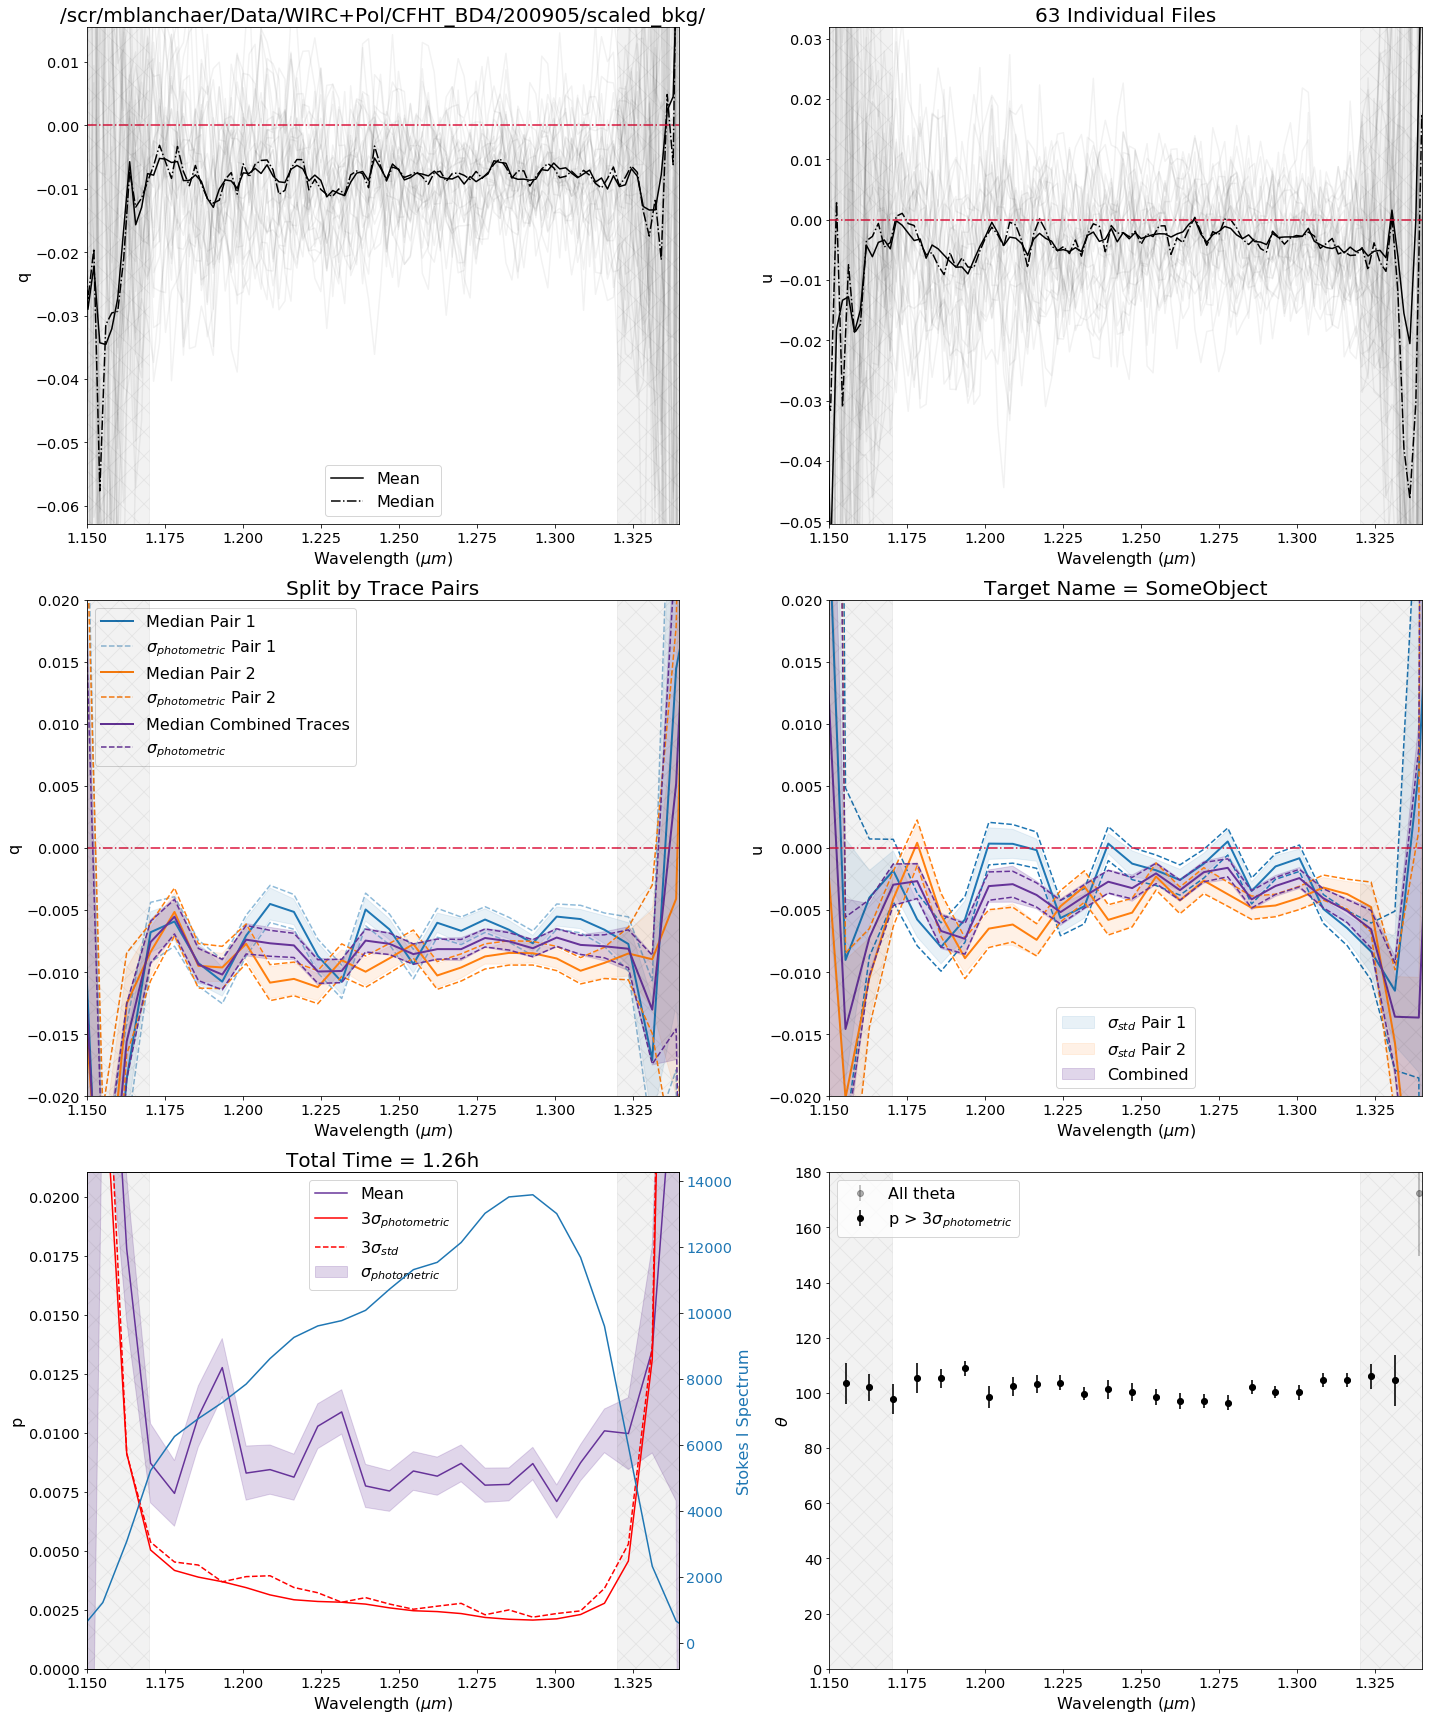

In [11]:
wd.plot_dataset_polarization_summary(data_directory,save=False,verbose=True,target_name="SomeObject")

### Variability Summary

The variability summary plot looks for variability in your dataset. In the top row we look at the sum of your trace spectra over time and take a lomb-scargle. In the second row, we do the same for q and u (i.e. the broadband value for q and u). In the third row, we bin together your spectra in time into `n_time_bins` bins. In the fourth row we bin together your spectra in spectral bins and plot them against time. 

Among other input arguments, you can also include a known period in hours if your object is known to be variable. 

(63,)
3


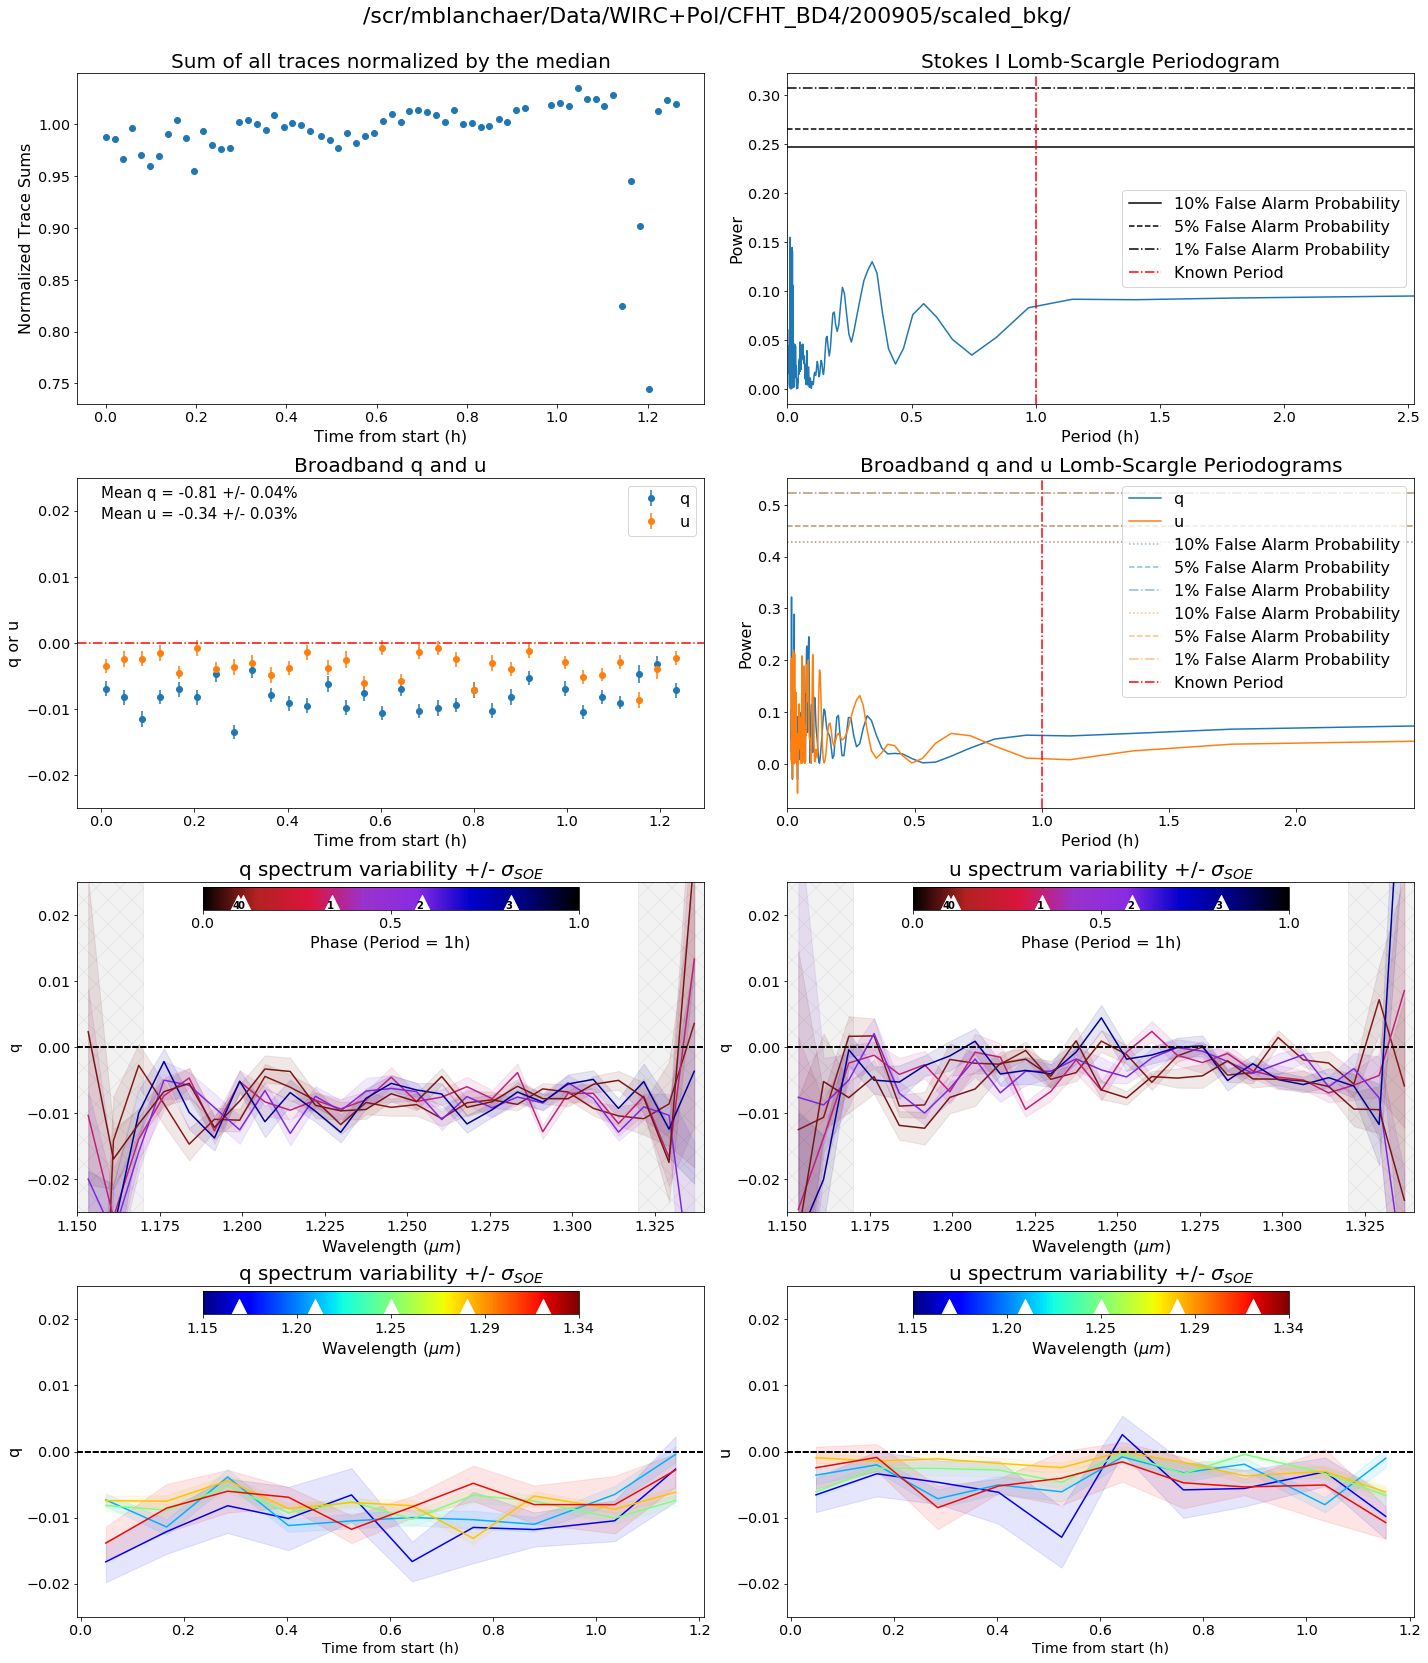

In [18]:
known_period=1
wd.plot_dataset_variability_summary(data_directory,save=False,known_period=known_period,
                                    n_time_bins=5,target_name="SomeTarget")

### Broadband Summary

We can also examine the different results one gets when varying the location of where you start to sum your flux for broadband measurements. 

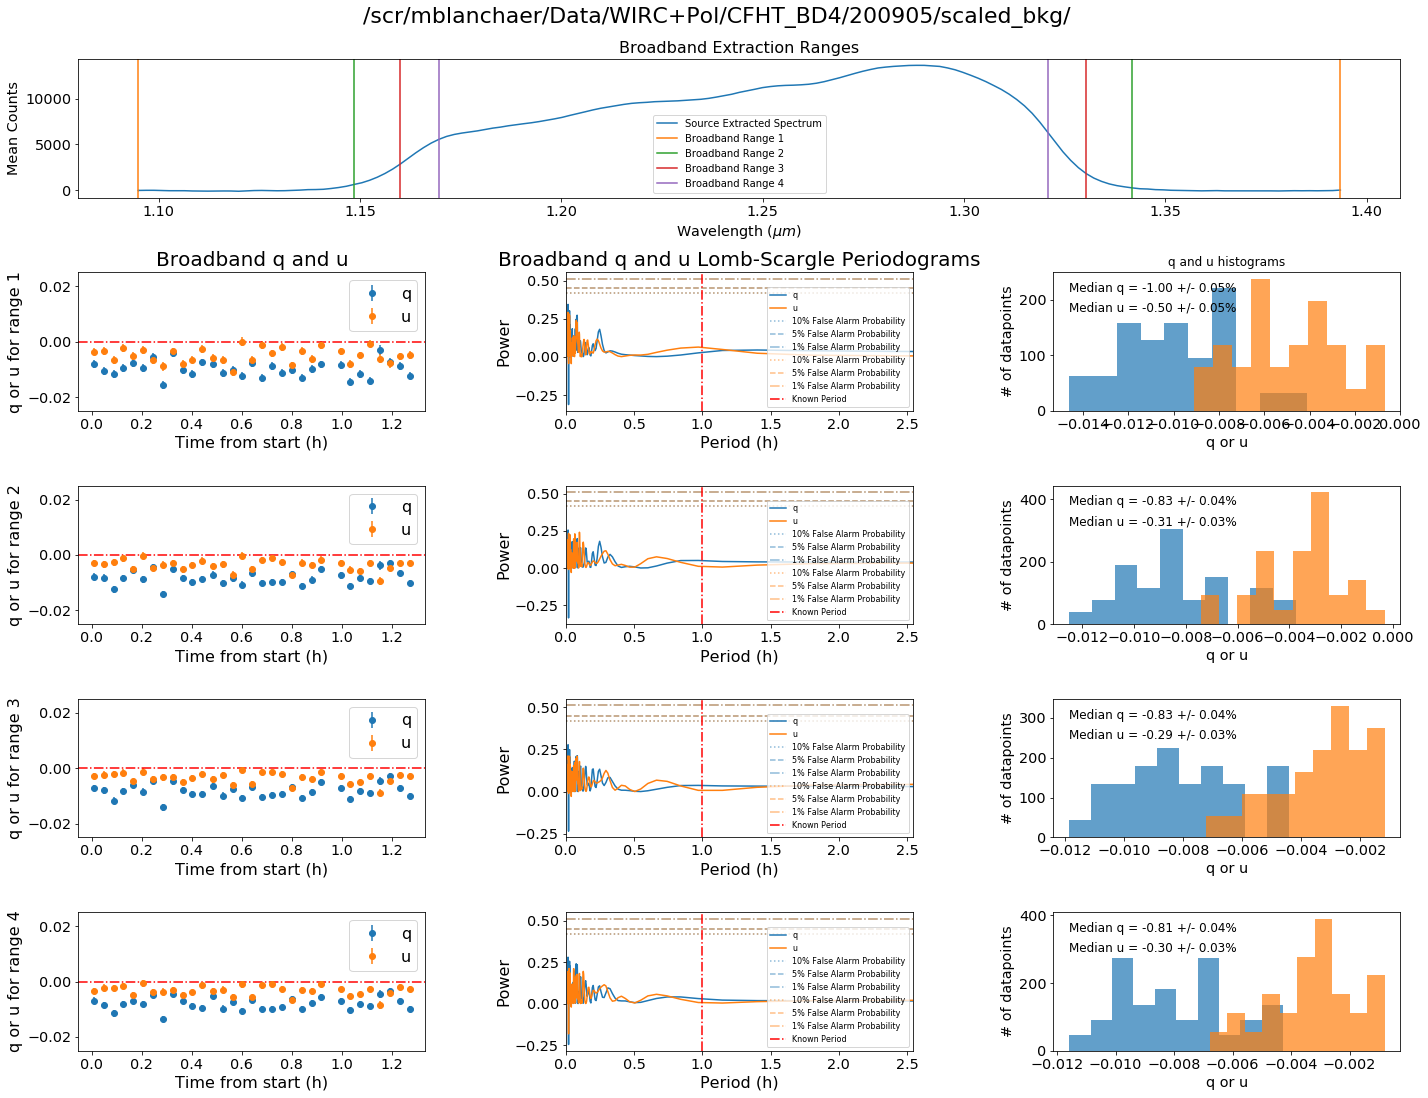

In [22]:
wd.plot_dataset_broadband_summary(data_directory,save=False,known_period=known_period,target_name="Some Object",
                                  calibrate=False)